<a href="https://colab.research.google.com/github/NinaAbeyratne/domain-shift-medical-segmentation/blob/main/Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [20]:
# Create model directory
Path('models').mkdir(exist_ok=True)

In [21]:
# Base directory
BASE_DIR = Path('/content/drive/MyDrive/MV CW/V2')

DATA_DIR = BASE_DIR / 'data' / 'processed'
print(BASE_DIR)

/content/drive/MyDrive/MV CW/V2


## Dataset (PyTorch)

In [40]:
class MedicalSegmentationDataset(Dataset):
    """
    PyTorch Dataset for medical image segmentation.

    Args:
        images: Numpy array of images [N, H, W]
        masks: Numpy array of binary masks [N, H, W]
    """
    def __init__(self, images, masks):
        self.images = torch.FloatTensor(images)  # [N, H, W]
        self.masks = torch.FloatTensor(masks)    # [N, H, W]

    def __len__(self):
        return len(self.images)

    # def __getitem__(self, idx):
    #     image = self.images[idx].unsqueeze(0).contiguous()
    #     mask = self.masks[idx].unsqueeze(0).contiguous()
    #     return image, mask

    def __getitem__(self, idx):
        image = self.images[idx]  # already [1, H, W], no unsqueeze
        mask = self.masks[idx]    # already [1, H, W], no unsqueeze
        return image, mask

## Load Preprocessed Data

In [41]:
synthetic_train_images = np.load(BASE_DIR / 'data/processed/synthetic_train_images.npy')
synthetic_train_masks = np.load(BASE_DIR / 'data/processed/synthetic_train_masks.npy')
synthetic_val_images = np.load(BASE_DIR / 'data/processed/synthetic_val_images.npy')
synthetic_val_masks = np.load(BASE_DIR / 'data/processed/synthetic_val_masks.npy')

print(f"Synthetic training set: {synthetic_train_images.shape}")
print(f"Synthetic validation set: {synthetic_val_images.shape}")

Synthetic training set: (800, 1, 256, 256)
Synthetic validation set: (100, 1, 256, 256)


In [42]:
# Create datasets
train_dataset = MedicalSegmentationDataset(synthetic_train_images, synthetic_train_masks)
val_dataset = MedicalSegmentationDataset(synthetic_val_images, synthetic_val_masks)

# Create dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"\nBatch size: {batch_size}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")


Batch size: 16
Training batches: 50
Validation batches: 7


# U-Net Model

In [43]:
class DoubleConv(nn.Module):
    """
    Double convolution block: Conv -> BatchNorm -> ReLU -> Conv -> BatchNorm -> ReLU

    Standard building block in U-Net architecture.
    """
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [44]:
class UNet(nn.Module):
    """
    U-Net architecture for medical image segmentation.

    Architecture:
        Encoder: 64 -> 128 -> 256 -> 512 -> 1024 channels
        Decoder: 1024 -> 512 -> 256 -> 128 -> 64 channels
        Output: 1 channel (binary segmentation)

    Args:
        in_channels: Number of input channels (1 for grayscale)
        out_channels: Number of output channels (1 for binary segmentation)
    """
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        # Encoder (downsampling path)
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # Decoder (upsampling path)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)  # 1024 = 512 (upconv) + 512 (skip)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)   # 512 = 256 (upconv) + 256 (skip)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)   # 256 = 128 (upconv) + 128 (skip)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)    # 128 = 64 (upconv) + 64 (skip)

        # Output layer
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder with skip connection storage
        enc1 = self.enc1(x)          # [B, 64, 256, 256]
        pool1 = self.pool1(enc1)     # [B, 64, 128, 128]

        enc2 = self.enc2(pool1)      # [B, 128, 128, 128]
        pool2 = self.pool2(enc2)     # [B, 128, 64, 64]

        enc3 = self.enc3(pool2)      # [B, 256, 64, 64]
        pool3 = self.pool3(enc3)     # [B, 256, 32, 32]

        enc4 = self.enc4(pool3)      # [B, 512, 32, 32]
        pool4 = self.pool4(enc4)     # [B, 512, 16, 16]

        # Bottleneck
        bottleneck = self.bottleneck(pool4)  # [B, 1024, 16, 16]

        # Decoder with skip connections
        up4 = self.upconv4(bottleneck)       # [B, 512, 32, 32]
        cat4 = torch.cat([up4, enc4], dim=1) # [B, 1024, 32, 32]
        dec4 = self.dec4(cat4)               # [B, 512, 32, 32]

        up3 = self.upconv3(dec4)             # [B, 256, 64, 64]
        cat3 = torch.cat([up3, enc3], dim=1) # [B, 512, 64, 64]
        dec3 = self.dec3(cat3)               # [B, 256, 64, 64]

        up2 = self.upconv2(dec3)             # [B, 128, 128, 128]
        cat2 = torch.cat([up2, enc2], dim=1) # [B, 256, 128, 128]
        dec2 = self.dec2(cat2)               # [B, 128, 128, 128]

        up1 = self.upconv1(dec2)             # [B, 64, 256, 256]
        cat1 = torch.cat([up1, enc1], dim=1) # [B, 128, 256, 256]
        dec1 = self.dec1(cat1)               # [B, 64, 256, 256]

        # Output
        out = self.out(dec1)                 # [B, 1, 256, 256]
        out = self.sigmoid(out)              # Apply sigmoid for binary segmentation

        return out

In [45]:
# Initialize model
model = UNet(in_channels=1, out_channels=1).to(device)

In [46]:
# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [47]:
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\nModel summary:")
print(model)

Total parameters: 31,036,481
Trainable parameters: 31,036,481

Model summary:
UNet(
  (enc1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      

A standard U-Net architecture with approximately 31 million trainable parameters was implemented. The model consists of a symmetric encoder–decoder structure with skip connections and Batch Normalization after each convolutional layer. The network was trained from scratch on synthetic data

# Loss Function

In [48]:
class DiceBCELoss(nn.Module):
    """
    Combined Dice Loss and Binary Cross-Entropy Loss.

    Dice Loss addresses class imbalance and directly optimizes overlap.
    BCE Loss provides stable pixel-wise gradients.
    """
    def __init__(self, weight_bce=0.5, weight_dice=0.5):
        super(DiceBCELoss, self).__init__()
        self.weight_bce = weight_bce
        self.weight_dice = weight_dice
        self.bce = nn.BCELoss()

    def forward(self, pred, target):
        # Binary Cross-Entropy
        bce_loss = self.bce(pred, target)

        # Dice Loss
        smooth = 1e-5  # Avoid division by zero
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)

        intersection = (pred_flat * target_flat).sum()
        dice_coeff = (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)
        dice_loss = 1 - dice_coeff

        # Combined loss
        total_loss = self.weight_bce * bce_loss + self.weight_dice * dice_loss

        return total_loss, bce_loss.item(), dice_loss.item()

In [49]:
criterion = DiceBCELoss(weight_bce=0.5, weight_dice=0.5)

# Training

In [50]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 50

In [51]:
print("\n" + "="*70)
print("TRAINING CONFIGURATION")
print("="*70)
print(f"Optimizer: Adam")
print(f"Learning rate: 1e-4")
print(f"Number of epochs: {num_epochs}")
print(f"Batch size: {batch_size}")
print(f"Loss function: Combined BCE + Dice")


TRAINING CONFIGURATION
Optimizer: Adam
Learning rate: 1e-4
Number of epochs: 50
Batch size: 16
Loss function: Combined BCE + Dice


In [52]:
def calculate_dice_coefficient(pred, target, threshold=0.5):
    """
    Calculate Dice coefficient for binary segmentation.

    Args:
        pred: Predicted probabilities [B, 1, H, W]
        target: Ground truth binary masks [B, 1, H, W]
        threshold: Probability threshold for binary prediction

    Returns:
        dice: Dice coefficient (scalar)
    """
    pred_binary = (pred > threshold).float()

    smooth = 1e-5
    pred_flat = pred_binary.view(-1)
    target_flat = target.view(-1)

    intersection = (pred_flat * target_flat).sum()
    dice = (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)

    return dice.item()

In [53]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()

    total_loss = 0.0
    total_bce = 0.0
    total_dice_loss = 0.0
    total_dice_score = 0.0

    pbar = tqdm(loader, desc='Training')
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss, bce, dice_loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        def plot_grad_flow(model):
            ave_grads = []
            max_grads= []
            layers = []
            for name, param in model.named_parameters():
                if param.requires_grad and "bias" not in name:
                    layers.append(name)
                    ave_grads.append(param.grad.abs().mean().cpu())
                    max_grads.append(param.grad.abs().max().cpu())

            plt.figure(figsize=(12,5))
            plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.3, lw=1, color="c", label='max-gradient')
            plt.bar(np.arange(len(ave_grads)), ave_grads, alpha=0.3, lw=1, color="b", label='mean-gradient')
            plt.xticks(range(0,len(ave_grads)), layers, rotation="vertical")
            plt.xlabel("Layers")
            plt.ylabel("Gradient value")
            plt.title("Gradient flow per layer")
            plt.grid(alpha=0.3)
            plt.legend()
            plt.tight_layout()
            plt.show()



        # Metrics
        dice_score = calculate_dice_coefficient(outputs, masks)

        total_loss += loss.item()
        total_bce += bce
        total_dice_loss += dice_loss
        total_dice_score += dice_score

        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'dice': f'{dice_score:.4f}'
        })

    n_batches = len(loader)
    return {
        'loss': total_loss / n_batches,
        'bce': total_bce / n_batches,
        'dice_loss': total_dice_loss / n_batches,
        'dice_score': total_dice_score / n_batches
    }

In [54]:
def validate_epoch(model, loader, criterion, device):
    """Validate for one epoch."""
    model.eval()

    total_loss = 0.0
    total_bce = 0.0
    total_dice_loss = 0.0
    total_dice_score = 0.0

    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation')
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            loss, bce, dice_loss = criterion(outputs, masks)

            # Metrics
            dice_score = calculate_dice_coefficient(outputs, masks)

            total_loss += loss.item()
            total_bce += bce
            total_dice_loss += dice_loss
            total_dice_score += dice_score

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{dice_score:.4f}'
            })

    n_batches = len(loader)
    return {
        'loss': total_loss / n_batches,
        'bce': total_bce / n_batches,
        'dice_loss': total_dice_loss / n_batches,
        'dice_score': total_dice_score / n_batches
    }

In [55]:
print("\n" + "="*70)
print("STARTING TRAINING")
print("="*70)

history = {
    'train_loss': [],
    'train_dice': [],
    'val_loss': [],
    'val_dice': []
}

best_val_dice = 0.0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Train
    train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_metrics = validate_epoch(model, val_loader, criterion, device)

    # Store history
    history['train_loss'].append(train_metrics['loss'])
    history['train_dice'].append(train_metrics['dice_score'])
    history['val_loss'].append(val_metrics['loss'])
    history['val_dice'].append(val_metrics['dice_score'])

    # Print summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_metrics['loss']:.4f} | Train Dice: {train_metrics['dice_score']:.4f}")
    print(f"  Val Loss:   {val_metrics['loss']:.4f} | Val Dice:   {val_metrics['dice_score']:.4f}")

    # Save best model
    if val_metrics['dice_score'] > best_val_dice:
        best_val_dice = val_metrics['dice_score']
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_dice': best_val_dice,
        }, 'models/unet_best.pth')
        print(f"  → Best model saved! (Val Dice: {best_val_dice:.4f})")


STARTING TRAINING

Epoch 1/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.31it/s, loss=0.3039, dice=0.9838]



Epoch 1 Summary:
  Train Loss: 0.3797 | Train Dice: 0.9574
  Val Loss:   0.3202 | Val Dice:   0.9832
  → Best model saved! (Val Dice: 0.9832)

Epoch 2/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.17it/s, loss=0.2699, dice=0.9941]



Epoch 2 Summary:
  Train Loss: 0.3014 | Train Dice: 0.9921
  Val Loss:   0.2856 | Val Dice:   0.9935
  → Best model saved! (Val Dice: 0.9935)

Epoch 3/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.24it/s, loss=0.2418, dice=0.9962]



Epoch 3 Summary:
  Train Loss: 0.2728 | Train Dice: 0.9951
  Val Loss:   0.2566 | Val Dice:   0.9958
  → Best model saved! (Val Dice: 0.9958)

Epoch 4/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.23it/s, loss=0.2209, dice=0.9981]



Epoch 4 Summary:
  Train Loss: 0.2471 | Train Dice: 0.9969
  Val Loss:   0.2348 | Val Dice:   0.9977
  → Best model saved! (Val Dice: 0.9977)

Epoch 5/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.23it/s, loss=0.2032, dice=0.9994]



Epoch 5 Summary:
  Train Loss: 0.2259 | Train Dice: 0.9984
  Val Loss:   0.2165 | Val Dice:   0.9992
  → Best model saved! (Val Dice: 0.9992)

Epoch 6/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.23it/s, loss=0.1840, dice=0.9996]



Epoch 6 Summary:
  Train Loss: 0.2068 | Train Dice: 0.9993
  Val Loss:   0.1965 | Val Dice:   0.9995
  → Best model saved! (Val Dice: 0.9995)

Epoch 7/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.24it/s, loss=0.1696, dice=0.9998]



Epoch 7 Summary:
  Train Loss: 0.1892 | Train Dice: 0.9996
  Val Loss:   0.1816 | Val Dice:   0.9997
  → Best model saved! (Val Dice: 0.9997)

Epoch 8/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.21it/s, loss=0.1548, dice=0.9998]



Epoch 8 Summary:
  Train Loss: 0.1729 | Train Dice: 0.9997
  Val Loss:   0.1661 | Val Dice:   0.9998
  → Best model saved! (Val Dice: 0.9998)

Epoch 9/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.24it/s, loss=0.1400, dice=0.9998]



Epoch 9 Summary:
  Train Loss: 0.1580 | Train Dice: 0.9998
  Val Loss:   0.1506 | Val Dice:   0.9998
  → Best model saved! (Val Dice: 0.9998)

Epoch 10/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.23it/s, loss=0.1261, dice=0.9999]



Epoch 10 Summary:
  Train Loss: 0.1444 | Train Dice: 0.9998
  Val Loss:   0.1359 | Val Dice:   0.9999
  → Best model saved! (Val Dice: 0.9999)

Epoch 11/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.23it/s, loss=0.1169, dice=1.0000]



Epoch 11 Summary:
  Train Loss: 0.1317 | Train Dice: 0.9999
  Val Loss:   0.1261 | Val Dice:   0.9999
  → Best model saved! (Val Dice: 0.9999)

Epoch 12/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.20it/s, loss=0.1063, dice=1.0000]



Epoch 12 Summary:
  Train Loss: 0.1201 | Train Dice: 0.9999
  Val Loss:   0.1149 | Val Dice:   0.9999
  → Best model saved! (Val Dice: 0.9999)

Epoch 13/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.23it/s, loss=0.0957, dice=1.0000]



Epoch 13 Summary:
  Train Loss: 0.1097 | Train Dice: 0.9999
  Val Loss:   0.1036 | Val Dice:   1.0000
  → Best model saved! (Val Dice: 1.0000)

Epoch 14/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.21it/s, loss=0.0878, dice=1.0000]



Epoch 14 Summary:
  Train Loss: 0.1003 | Train Dice: 1.0000
  Val Loss:   0.0951 | Val Dice:   1.0000
  → Best model saved! (Val Dice: 1.0000)

Epoch 15/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.24it/s, loss=0.0803, dice=1.0000]



Epoch 15 Summary:
  Train Loss: 0.0918 | Train Dice: 1.0000
  Val Loss:   0.0871 | Val Dice:   1.0000
  → Best model saved! (Val Dice: 1.0000)

Epoch 16/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.22it/s, loss=0.0742, dice=1.0000]



Epoch 16 Summary:
  Train Loss: 0.0841 | Train Dice: 1.0000
  Val Loss:   0.0805 | Val Dice:   1.0000
  → Best model saved! (Val Dice: 1.0000)

Epoch 17/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.23it/s, loss=0.0672, dice=1.0000]



Epoch 17 Summary:
  Train Loss: 0.0772 | Train Dice: 1.0000
  Val Loss:   0.0730 | Val Dice:   1.0000
  → Best model saved! (Val Dice: 1.0000)

Epoch 18/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.26it/s, loss=0.0616, dice=1.0000]



Epoch 18 Summary:
  Train Loss: 0.0709 | Train Dice: 1.0000
  Val Loss:   0.0670 | Val Dice:   1.0000
  → Best model saved! (Val Dice: 1.0000)

Epoch 19/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.20it/s, loss=0.0563, dice=1.0000]



Epoch 19 Summary:
  Train Loss: 0.0652 | Train Dice: 1.0000
  Val Loss:   0.0614 | Val Dice:   1.0000
  → Best model saved! (Val Dice: 1.0000)

Epoch 20/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.25it/s, loss=0.0519, dice=1.0000]



Epoch 20 Summary:
  Train Loss: 0.0601 | Train Dice: 1.0000
  Val Loss:   0.0565 | Val Dice:   1.0000

Epoch 21/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.25it/s, loss=0.0485, dice=1.0000]



Epoch 21 Summary:
  Train Loss: 0.0555 | Train Dice: 1.0000
  Val Loss:   0.0530 | Val Dice:   1.0000
  → Best model saved! (Val Dice: 1.0000)

Epoch 22/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.26it/s, loss=0.0446, dice=1.0000]



Epoch 22 Summary:
  Train Loss: 0.0513 | Train Dice: 1.0000
  Val Loss:   0.0487 | Val Dice:   1.0000

Epoch 23/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.20it/s, loss=0.0414, dice=1.0000]



Epoch 23 Summary:
  Train Loss: 0.0475 | Train Dice: 1.0000
  Val Loss:   0.0453 | Val Dice:   1.0000

Epoch 24/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.25it/s, loss=0.0381, dice=1.0000]



Epoch 24 Summary:
  Train Loss: 0.0440 | Train Dice: 1.0000
  Val Loss:   0.0416 | Val Dice:   1.0000

Epoch 25/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.24it/s, loss=0.0361, dice=1.0000]



Epoch 25 Summary:
  Train Loss: 0.0409 | Train Dice: 1.0000
  Val Loss:   0.0395 | Val Dice:   1.0000
  → Best model saved! (Val Dice: 1.0000)

Epoch 26/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.23it/s, loss=0.0336, dice=1.0000]



Epoch 26 Summary:
  Train Loss: 0.0380 | Train Dice: 1.0000
  Val Loss:   0.0368 | Val Dice:   1.0000

Epoch 27/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.24it/s, loss=0.0312, dice=1.0000]



Epoch 27 Summary:
  Train Loss: 0.0355 | Train Dice: 1.0000
  Val Loss:   0.0341 | Val Dice:   1.0000
  → Best model saved! (Val Dice: 1.0000)

Epoch 28/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.22it/s, loss=0.0286, dice=1.0000]



Epoch 28 Summary:
  Train Loss: 0.0331 | Train Dice: 1.0000
  Val Loss:   0.0312 | Val Dice:   1.0000

Epoch 29/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.22it/s, loss=0.0269, dice=1.0000]



Epoch 29 Summary:
  Train Loss: 0.0309 | Train Dice: 1.0000
  Val Loss:   0.0295 | Val Dice:   1.0000

Epoch 30/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.23it/s, loss=0.0254, dice=1.0000]



Epoch 30 Summary:
  Train Loss: 0.0289 | Train Dice: 1.0000
  Val Loss:   0.0279 | Val Dice:   1.0000

Epoch 31/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.25it/s, loss=0.0240, dice=1.0000]



Epoch 31 Summary:
  Train Loss: 0.0271 | Train Dice: 1.0000
  Val Loss:   0.0263 | Val Dice:   1.0000
  → Best model saved! (Val Dice: 1.0000)

Epoch 32/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.24it/s, loss=0.0221, dice=1.0000]



Epoch 32 Summary:
  Train Loss: 0.0254 | Train Dice: 1.0000
  Val Loss:   0.0242 | Val Dice:   1.0000

Epoch 33/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.25it/s, loss=0.0209, dice=1.0000]



Epoch 33 Summary:
  Train Loss: 0.0239 | Train Dice: 1.0000
  Val Loss:   0.0229 | Val Dice:   1.0000

Epoch 34/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.25it/s, loss=0.0197, dice=1.0000]



Epoch 34 Summary:
  Train Loss: 0.0225 | Train Dice: 1.0000
  Val Loss:   0.0216 | Val Dice:   1.0000

Epoch 35/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.24it/s, loss=0.0187, dice=1.0000]



Epoch 35 Summary:
  Train Loss: 0.0211 | Train Dice: 1.0000
  Val Loss:   0.0206 | Val Dice:   1.0000

Epoch 36/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.25it/s, loss=0.0174, dice=1.0000]



Epoch 36 Summary:
  Train Loss: 0.0199 | Train Dice: 1.0000
  Val Loss:   0.0191 | Val Dice:   1.0000

Epoch 37/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.20it/s, loss=0.0166, dice=1.0000]



Epoch 37 Summary:
  Train Loss: 0.0188 | Train Dice: 1.0000
  Val Loss:   0.0182 | Val Dice:   1.0000

Epoch 38/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.23it/s, loss=0.0157, dice=1.0000]



Epoch 38 Summary:
  Train Loss: 0.0177 | Train Dice: 1.0000
  Val Loss:   0.0173 | Val Dice:   1.0000

Epoch 39/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.24it/s, loss=0.0149, dice=1.0000]



Epoch 39 Summary:
  Train Loss: 0.0168 | Train Dice: 1.0000
  Val Loss:   0.0163 | Val Dice:   1.0000

Epoch 40/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.24it/s, loss=0.0140, dice=1.0000]



Epoch 40 Summary:
  Train Loss: 0.0159 | Train Dice: 1.0000
  Val Loss:   0.0154 | Val Dice:   1.0000

Epoch 41/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.25it/s, loss=0.0132, dice=1.0000]



Epoch 41 Summary:
  Train Loss: 0.0150 | Train Dice: 1.0000
  Val Loss:   0.0145 | Val Dice:   1.0000
  → Best model saved! (Val Dice: 1.0000)

Epoch 42/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.18it/s, loss=0.0125, dice=1.0000]



Epoch 42 Summary:
  Train Loss: 0.0143 | Train Dice: 1.0000
  Val Loss:   0.0137 | Val Dice:   1.0000

Epoch 43/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.25it/s, loss=0.0118, dice=1.0000]



Epoch 43 Summary:
  Train Loss: 0.0135 | Train Dice: 1.0000
  Val Loss:   0.0129 | Val Dice:   1.0000

Epoch 44/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.23it/s, loss=0.0112, dice=1.0000]



Epoch 44 Summary:
  Train Loss: 0.0128 | Train Dice: 1.0000
  Val Loss:   0.0123 | Val Dice:   1.0000

Epoch 45/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.24it/s, loss=0.0109, dice=1.0000]



Epoch 45 Summary:
  Train Loss: 0.0122 | Train Dice: 1.0000
  Val Loss:   0.0119 | Val Dice:   1.0000

Epoch 46/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.25it/s, loss=0.0103, dice=1.0000]



Epoch 46 Summary:
  Train Loss: 0.0116 | Train Dice: 1.0000
  Val Loss:   0.0113 | Val Dice:   1.0000

Epoch 47/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.25it/s, loss=0.0097, dice=1.0000]



Epoch 47 Summary:
  Train Loss: 0.0110 | Train Dice: 1.0000
  Val Loss:   0.0106 | Val Dice:   1.0000
  → Best model saved! (Val Dice: 1.0000)

Epoch 48/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.18it/s, loss=0.0093, dice=1.0000]



Epoch 48 Summary:
  Train Loss: 0.0105 | Train Dice: 1.0000
  Val Loss:   0.0102 | Val Dice:   1.0000

Epoch 49/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.27it/s, loss=0.0089, dice=1.0000]



Epoch 49 Summary:
  Train Loss: 0.0100 | Train Dice: 1.0000
  Val Loss:   0.0098 | Val Dice:   1.0000

Epoch 50/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.27it/s, loss=0.0085, dice=1.0000]


Epoch 50 Summary:
  Train Loss: 0.0096 | Train Dice: 1.0000
  Val Loss:   0.0093 | Val Dice:   1.0000


In [56]:
# Save final model
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_dice': val_metrics['dice_score'],
}, 'models/unet_final.pth')

# Save training history
with open('models/training_history.pkl', 'wb') as f:
    pickle.dump(history, f)

print("Training completed and model saved")
print(f"Best validation Dice: {best_val_dice:.4f}")

Training completed and model saved
Best validation Dice: 1.0000


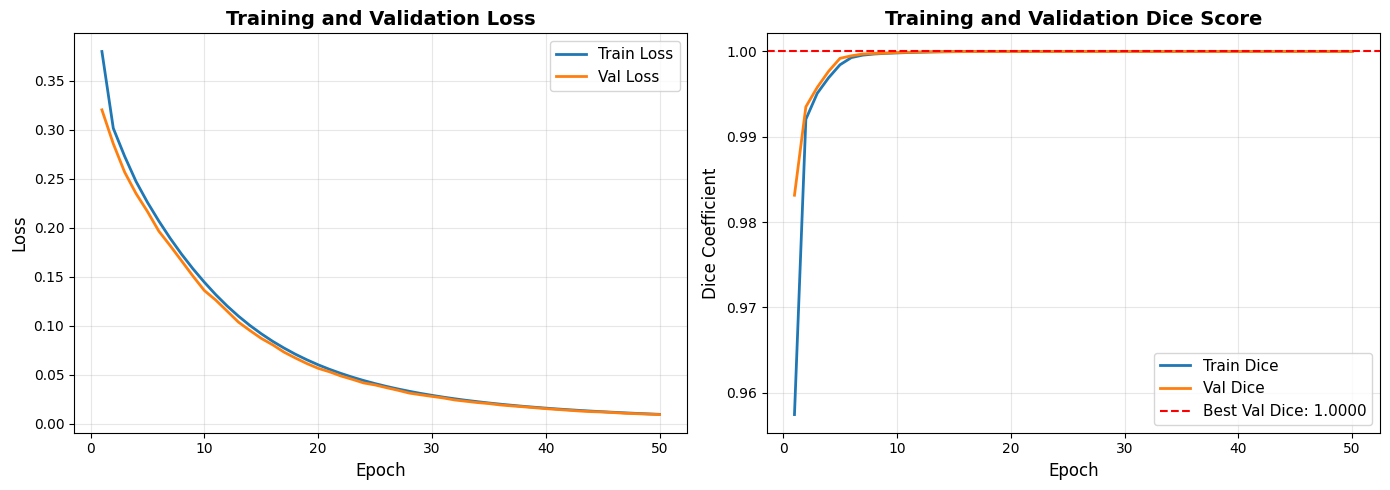


Training curves saved to models/training_curves.png


In [57]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
epochs_range = range(1, num_epochs + 1)
axes[0].plot(epochs_range, history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(epochs_range, history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Dice coefficient curves
axes[1].plot(epochs_range, history['train_dice'], label='Train Dice', linewidth=2)
axes[1].plot(epochs_range, history['val_dice'], label='Val Dice', linewidth=2)
axes[1].axhline(y=best_val_dice, color='r', linestyle='--',
                label=f'Best Val Dice: {best_val_dice:.4f}', linewidth=1.5)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Dice Coefficient', fontsize=12)
axes[1].set_title('Training and Validation Dice Score', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('models/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTraining curves saved to models/training_curves.png")

### Sample Predictions on Synthetic Validation Set

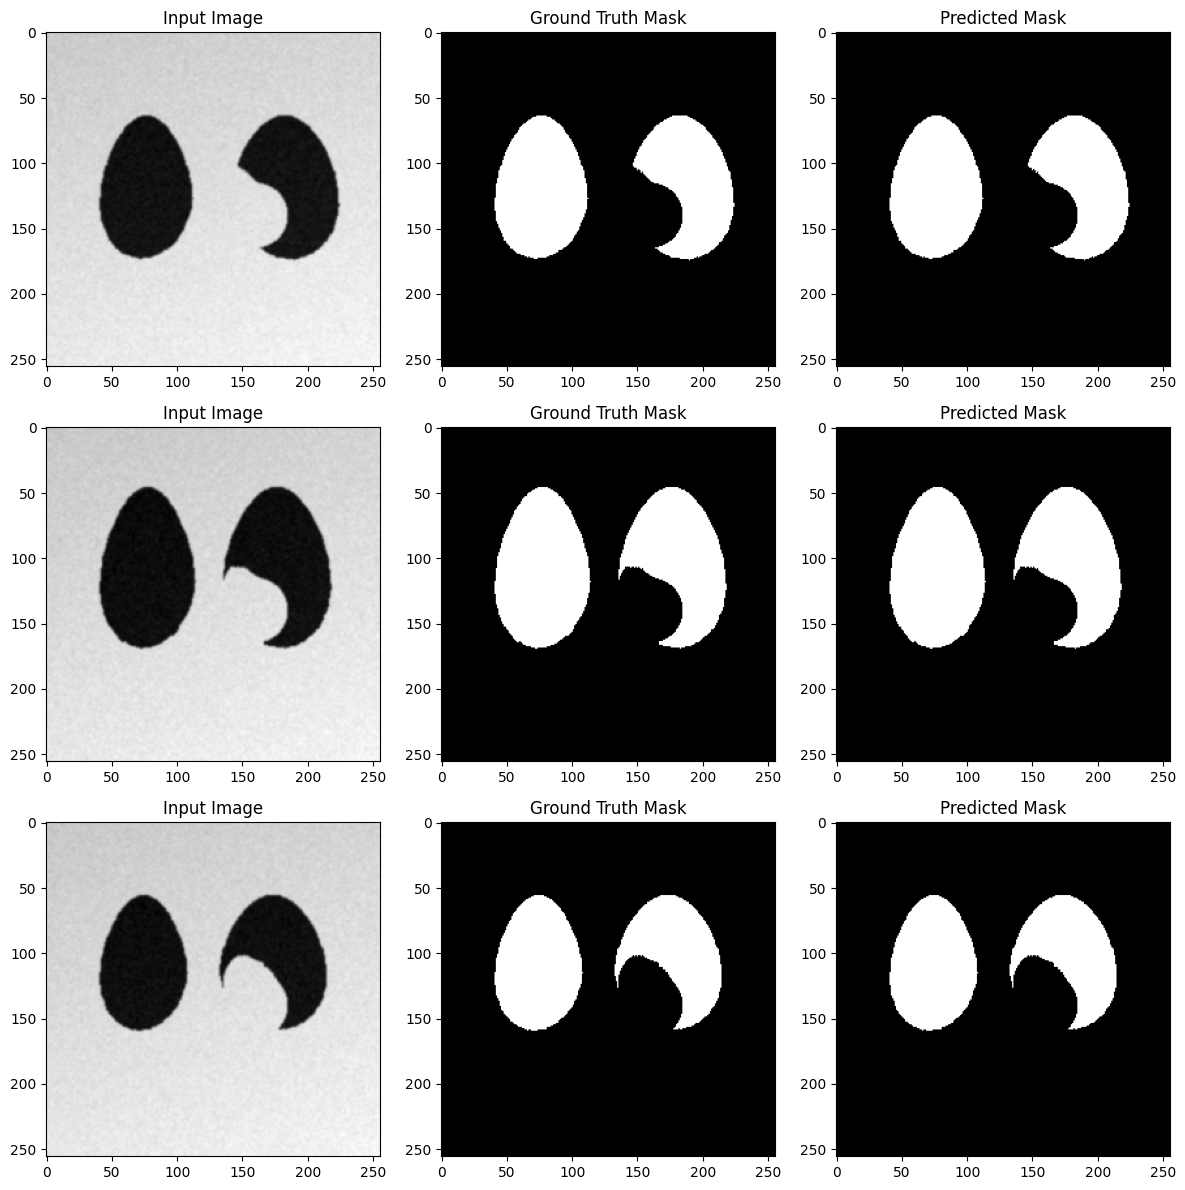

In [59]:
model.eval()
num_samples = 3
fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))

for i in range(num_samples):
    img = synthetic_val_images[i]   # [1, H, W]
    mask = synthetic_val_masks[i]   # [1, H, W]

    with torch.no_grad():
        input_tensor = torch.FloatTensor(img).unsqueeze(0).to(device)
        # shape: [1, 1, H, W]

        pred = model(input_tensor).cpu().squeeze().numpy()
        pred_binary = (pred > 0.5).astype(np.float32)

    axes[i, 0].imshow(img.squeeze(), cmap='gray')
    axes[i, 0].set_title('Input Image')

    axes[i, 1].imshow(mask.squeeze(), cmap='gray')
    axes[i, 1].set_title('Ground Truth Mask')

    axes[i, 2].imshow(pred_binary, cmap='gray')
    axes[i, 2].set_title('Predicted Mask')

plt.tight_layout()
plt.show()

### Dice Distribution

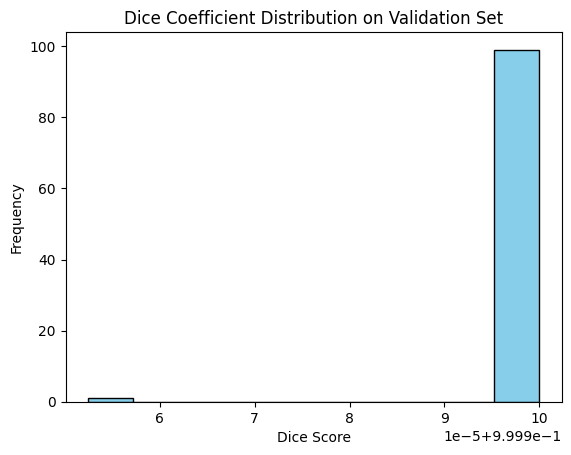

In [60]:
dice_scores = []
model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        for out, mask in zip(outputs, masks):
            dice_scores.append(calculate_dice_coefficient(out.unsqueeze(0), mask.unsqueeze(0)))

plt.hist(dice_scores, bins=10, color='skyblue', edgecolor='k')
plt.title("Dice Coefficient Distribution on Validation Set")
plt.xlabel("Dice Score")
plt.ylabel("Frequency")
plt.show()

In [65]:
history = {
    'train_loss': [],
    'train_bce': [],
    'train_dice_loss': [],
    'train_dice': [],
    'val_loss': [],
    'val_bce': [],
    'val_dice_loss': [],
    'val_dice': []
}

history['train_loss'].append(train_metrics['loss'])
history['train_bce'].append(train_metrics['bce'])
history['train_dice_loss'].append(train_metrics['dice_loss'])
history['train_dice'].append(train_metrics['dice_score'])

history['val_loss'].append(val_metrics['loss'])
history['val_bce'].append(val_metrics['bce'])
history['val_dice_loss'].append(val_metrics['dice_loss'])
history['val_dice'].append(val_metrics['dice_score'])

ValueError: x and y must have same first dimension, but have shapes (50,) and (1,)

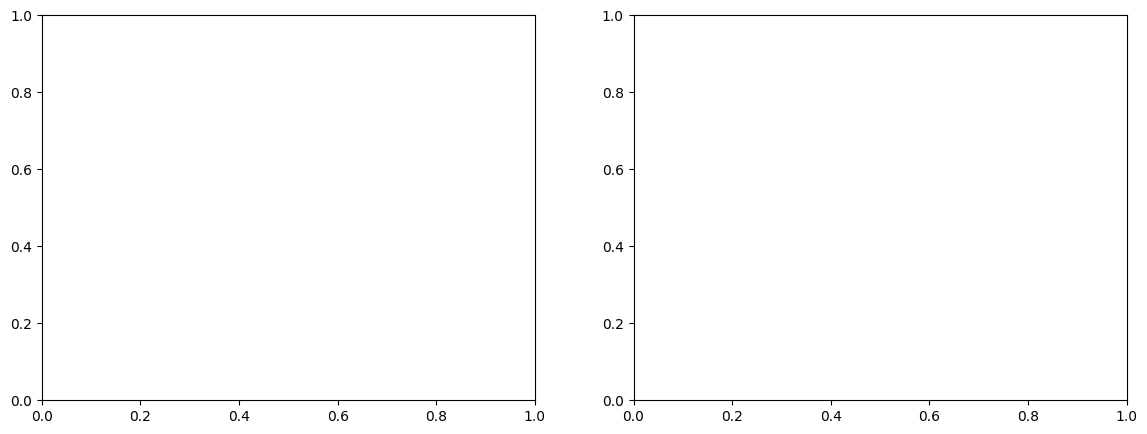

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, num_epochs + 1)

# BCE Loss
axes[0].plot(epochs_range, history['train_bce'], label='Train BCE', linewidth=2)
axes[0].plot(epochs_range, history['val_bce'], label='Val BCE', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('BCE Loss', fontsize=12)
axes[0].set_title('Binary Cross-Entropy Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Dice Loss
axes[1].plot(epochs_range, history['train_dice_loss'], label='Train Dice Loss', linewidth=2)
axes[1].plot(epochs_range, history['val_dice_loss'], label='Val Dice Loss', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Dice Loss', fontsize=12)
axes[1].set_title('Dice Loss', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('models/bce_dice_loss_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nBCE and Dice loss curves saved to models/bce_dice_loss_curves.png")


### Training time

In [70]:
import time

epoch_times = []

for epoch in range(5):
    start_time = time.time()

    # Train
    train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_metrics = validate_epoch(model, val_loader, criterion, device)

    # Record time
    epoch_duration = time.time() - start_time
    epoch_times.append(epoch_duration)

    print(f"\nEpoch {epoch+1} completed in {epoch_duration:.2f} seconds")


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.21it/s, loss=0.0054, dice=1.0000]



Epoch 1 completed in 41.90 seconds


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.27it/s, loss=0.0051, dice=1.0000]



Epoch 2 completed in 41.64 seconds


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.24it/s, loss=0.0049, dice=1.0000]



Epoch 3 completed in 41.55 seconds


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.25it/s, loss=0.0047, dice=1.0000]



Epoch 4 completed in 41.56 seconds


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.23it/s, loss=0.0046, dice=1.0000]


Epoch 5 completed in 41.57 seconds


ValueError: x and y must have same first dimension, but have shapes (50,) and (5,)

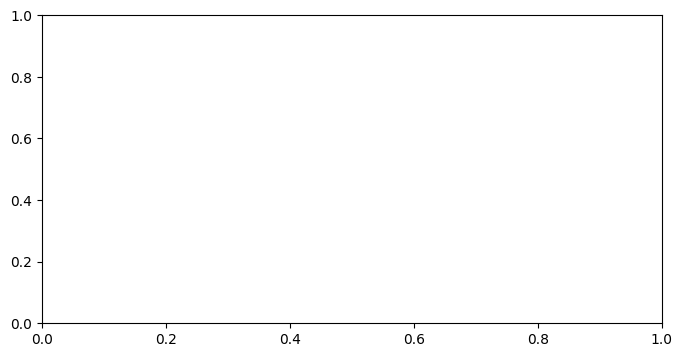

In [71]:
plt.figure(figsize=(8,4))
plt.plot(range(1, num_epochs+1), epoch_times, marker='o', color='teal')
plt.xlabel('Epoch')
plt.ylabel('Time (s)')
plt.title('Training Time per Epoch')
plt.grid(alpha=0.3)
plt.show()

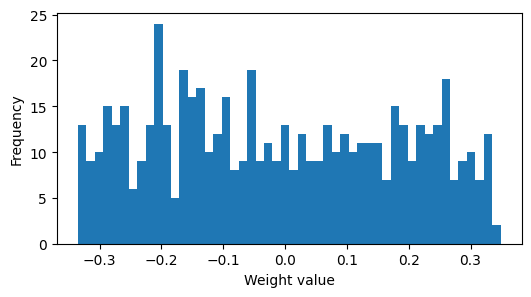

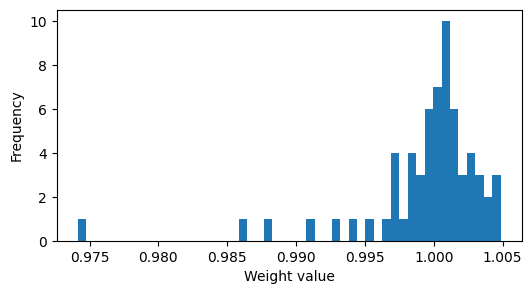

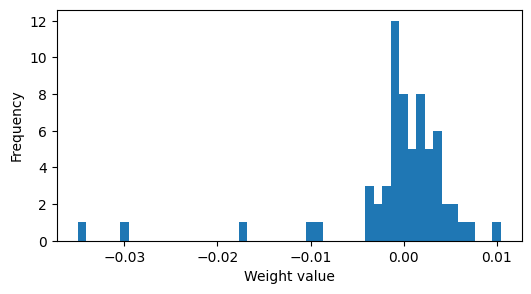

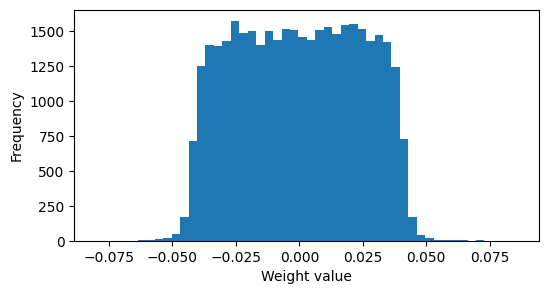

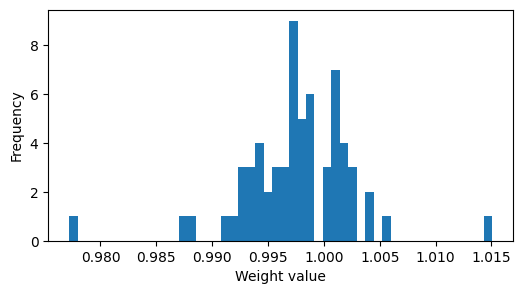

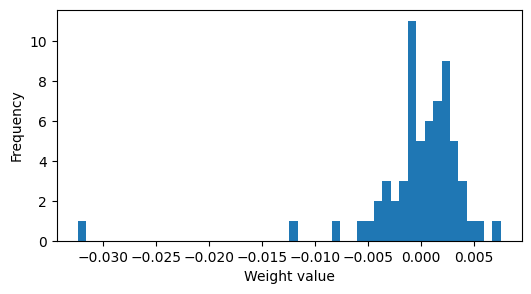

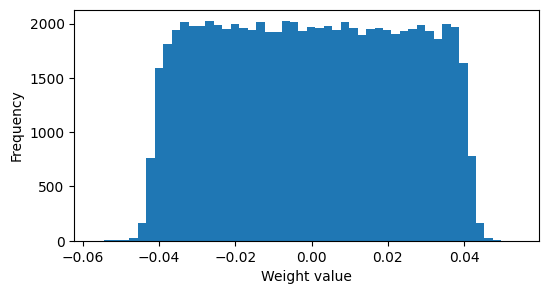

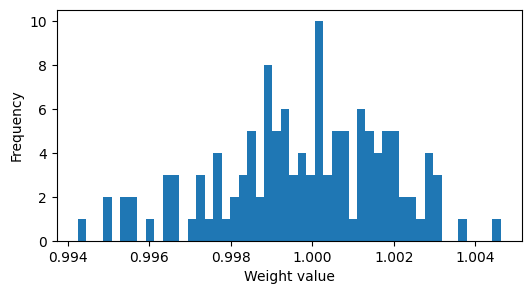

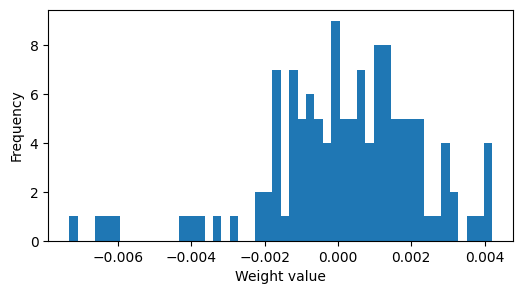

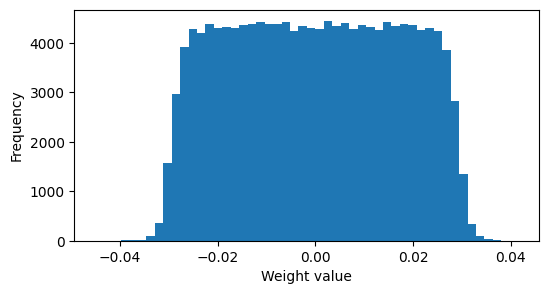

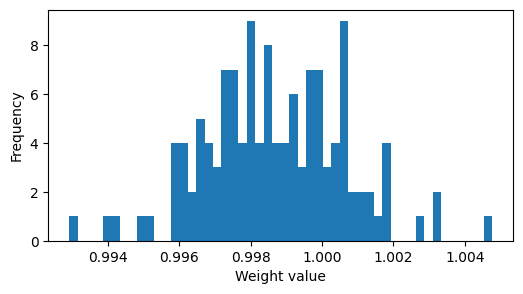

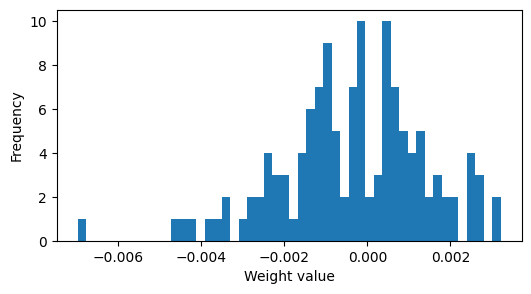

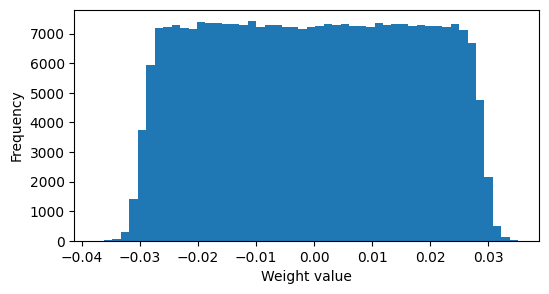

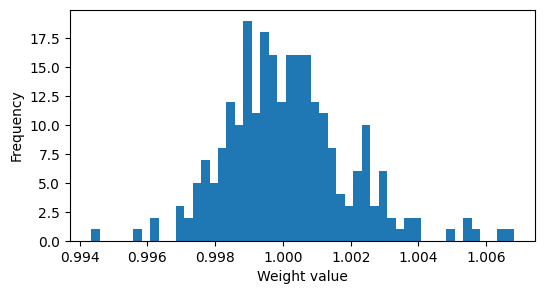

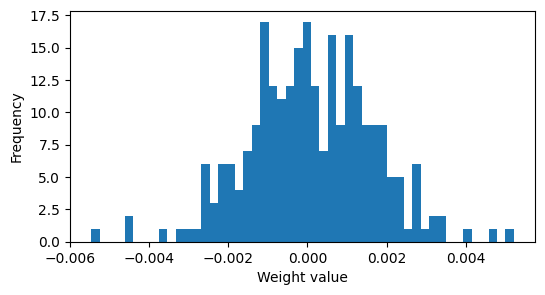

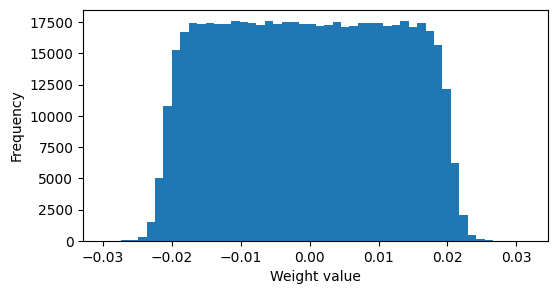

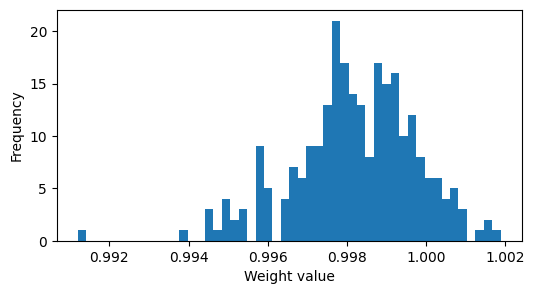

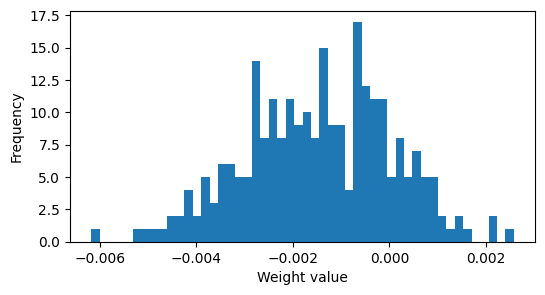

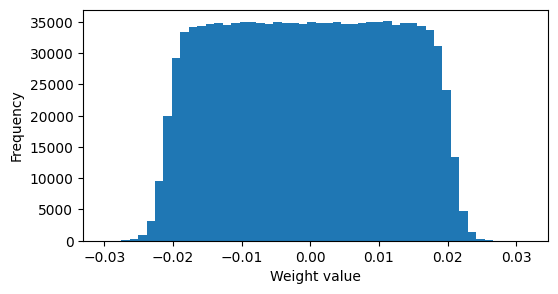

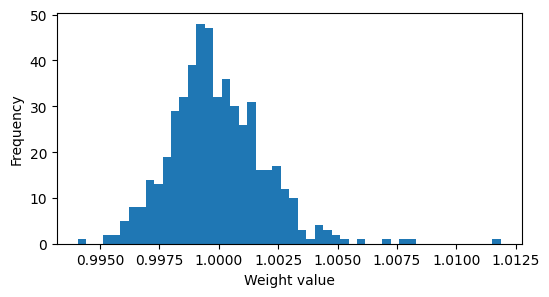

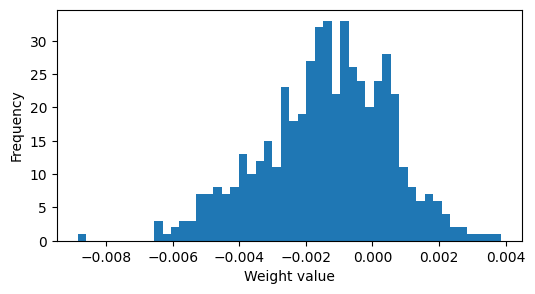

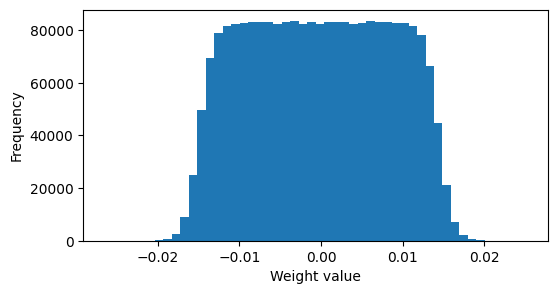

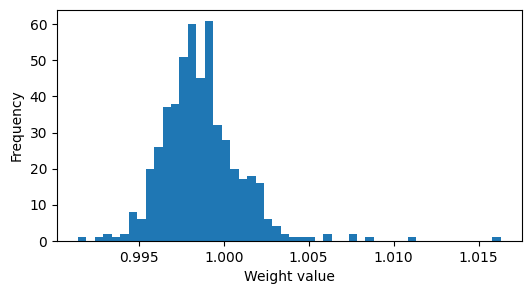

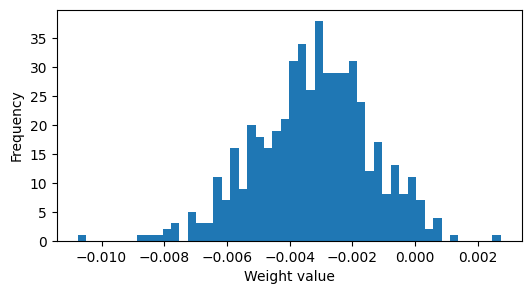

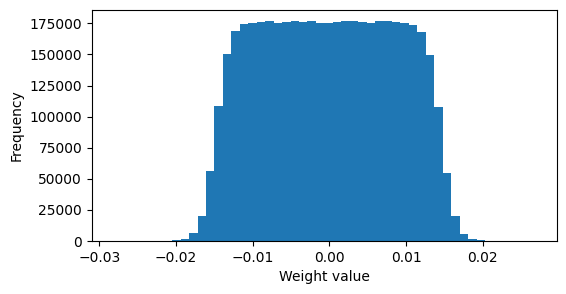

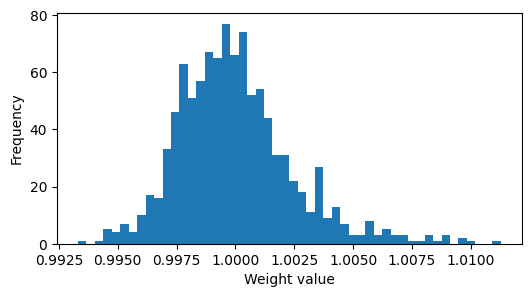

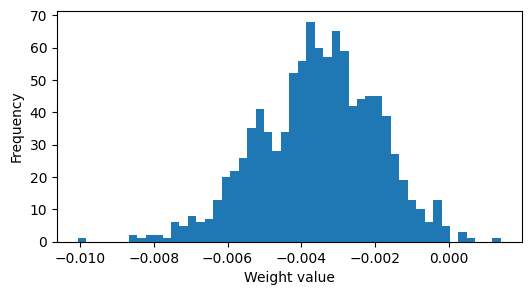

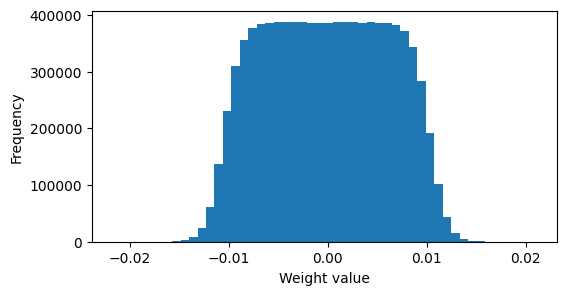

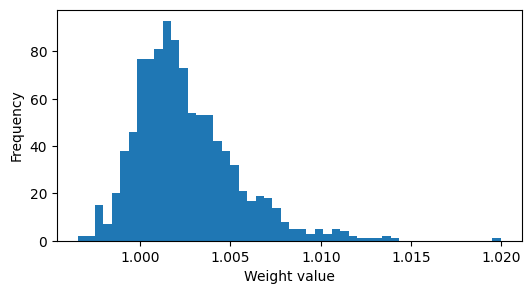

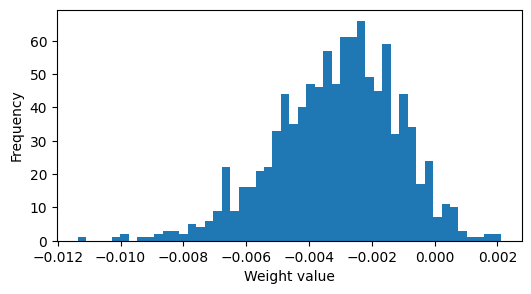

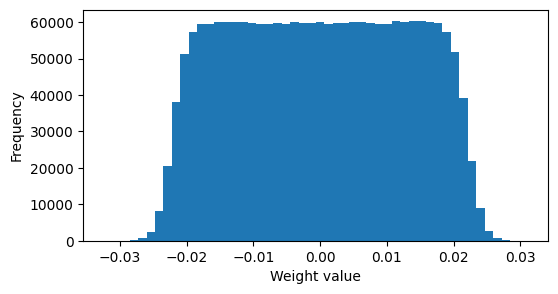

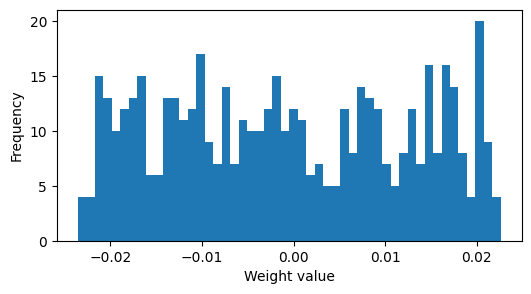

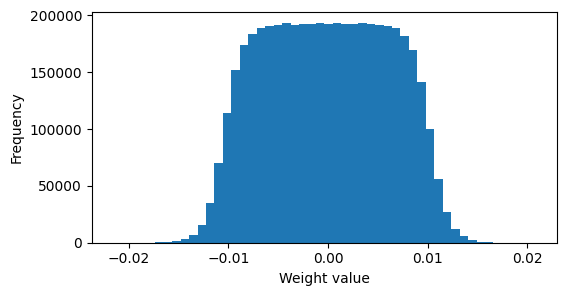

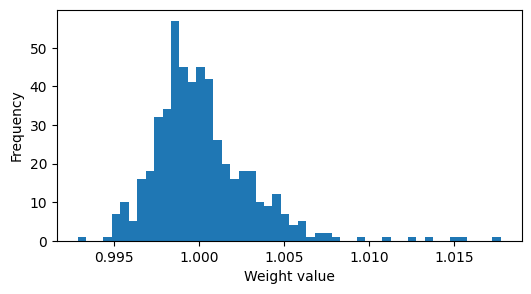

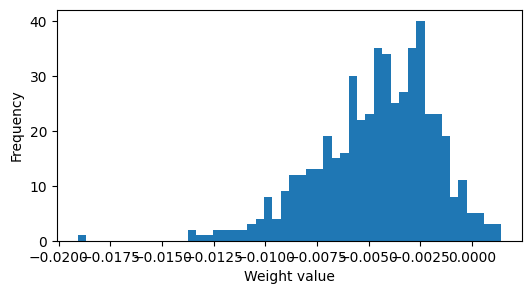

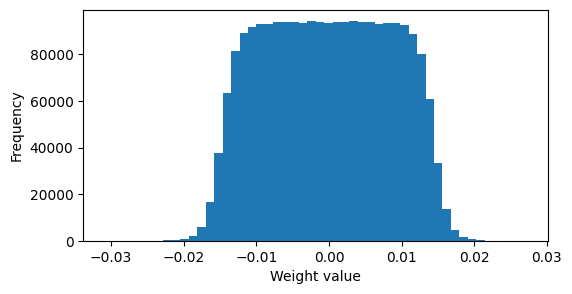

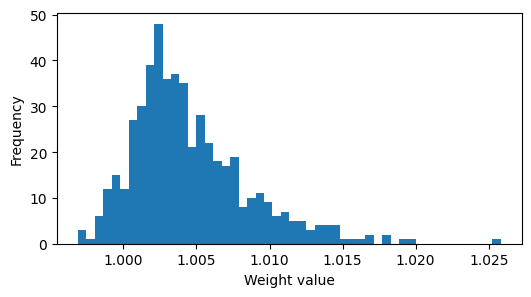

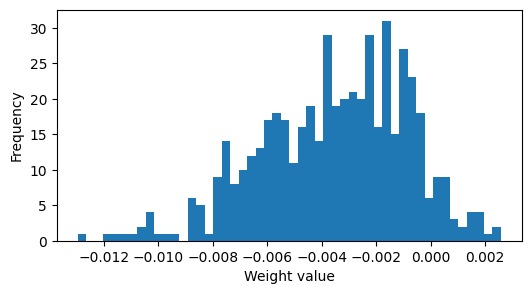

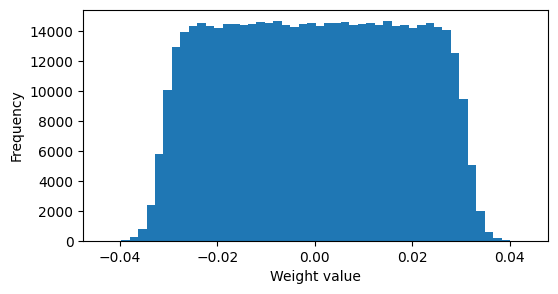

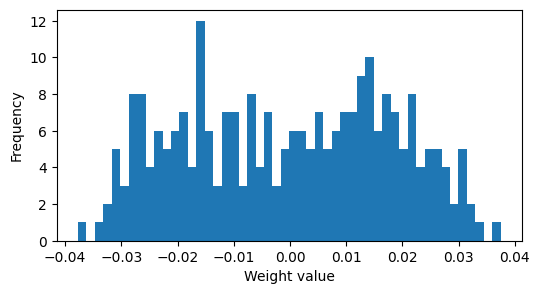

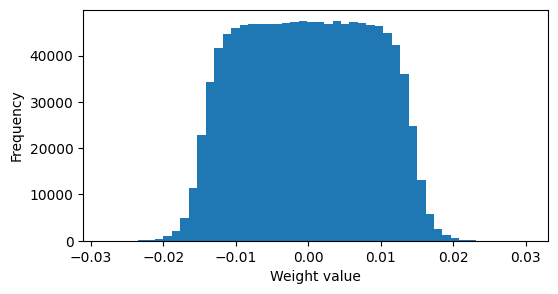

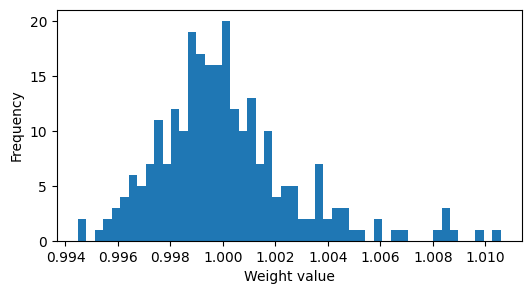

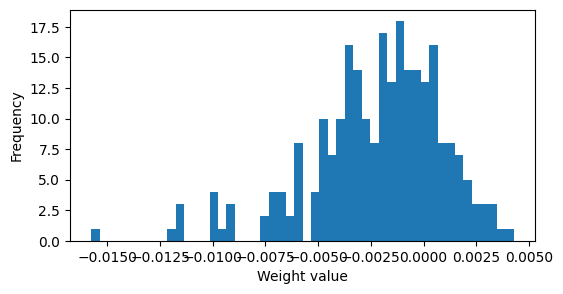

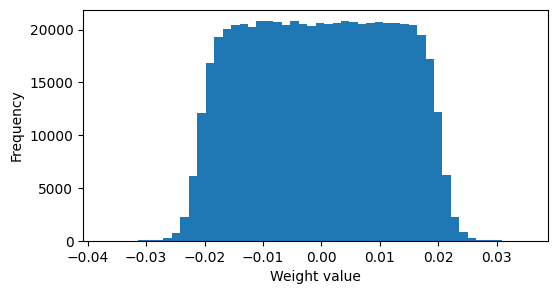

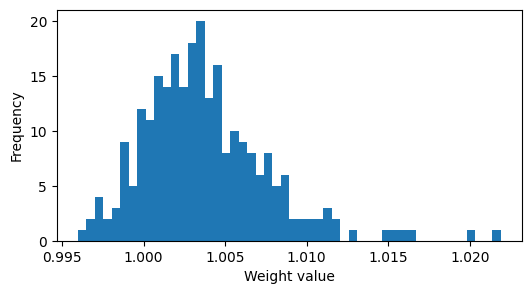

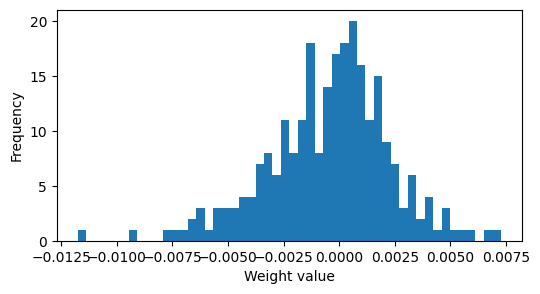

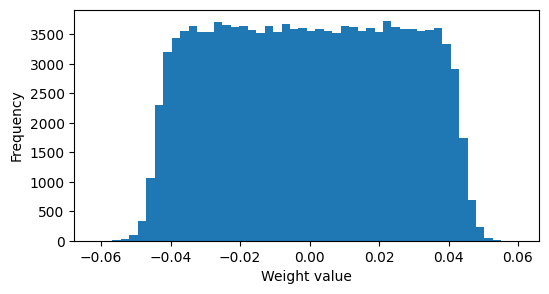

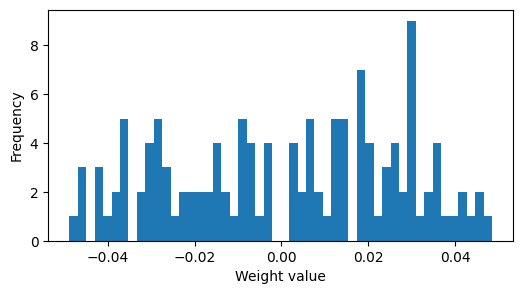

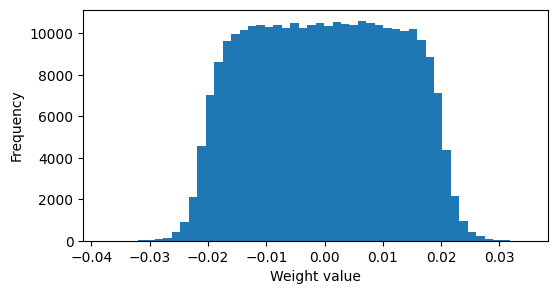

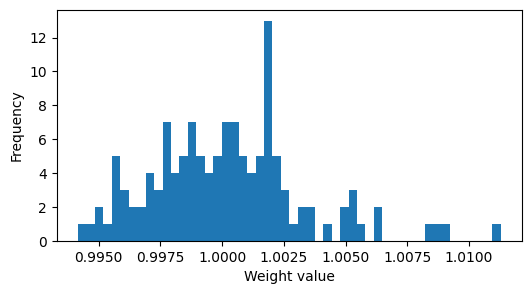

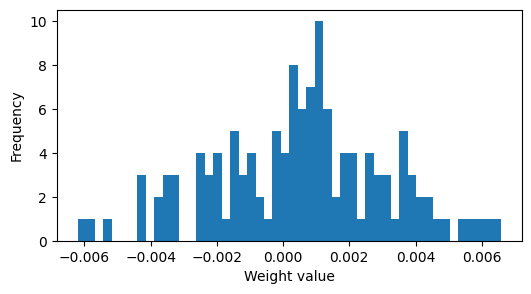

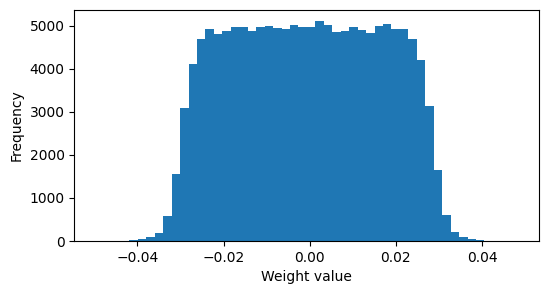

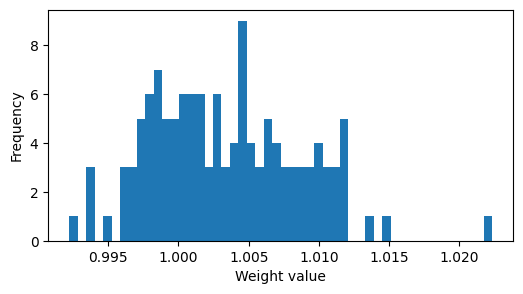

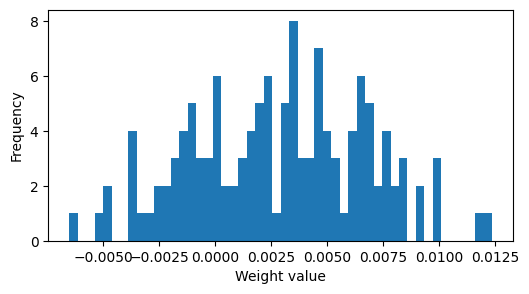

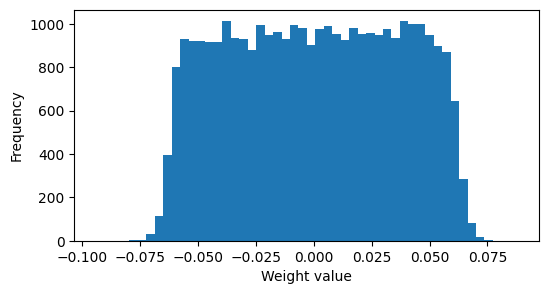

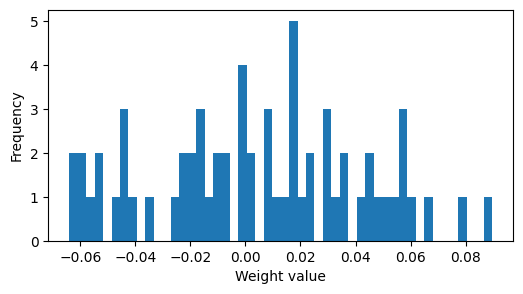

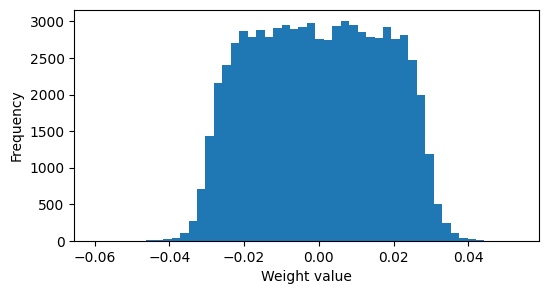

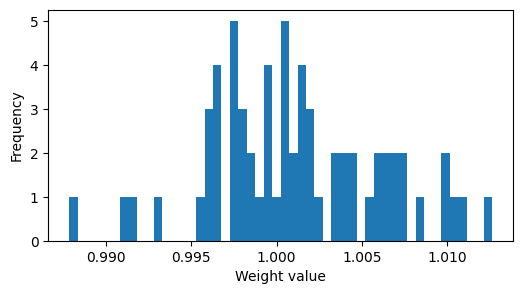

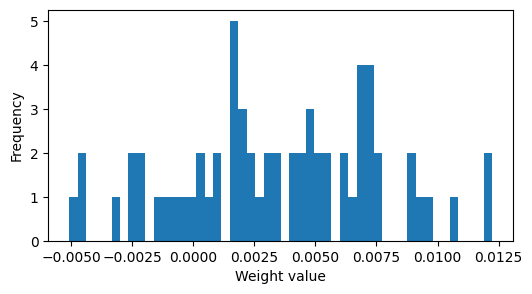

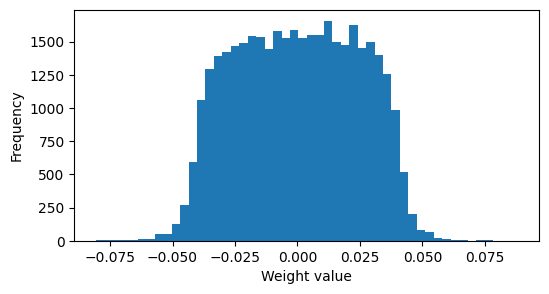

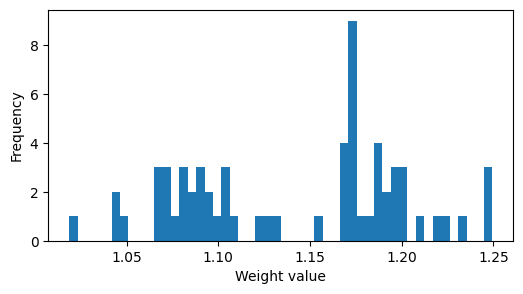

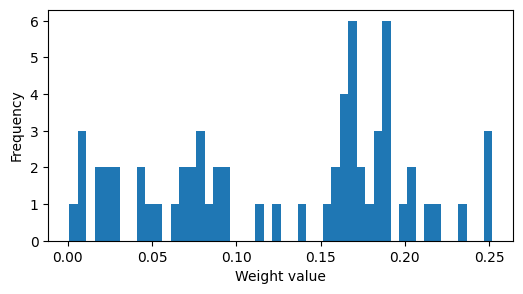

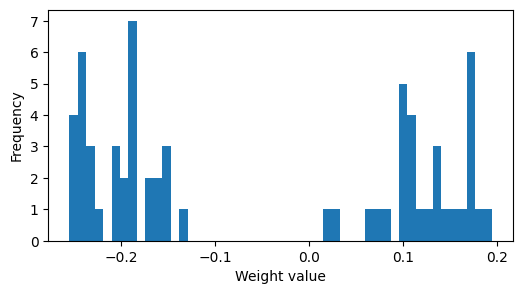

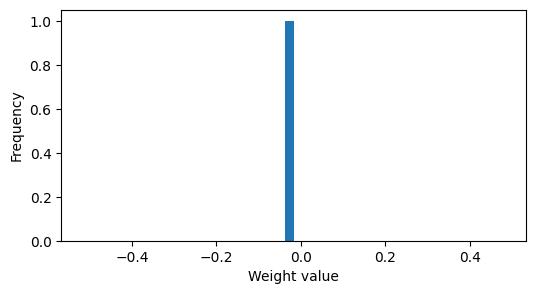

In [72]:
def plot_weight_histograms(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            plt.figure(figsize=(6,3))
            plt.hist(param.detach().cpu().numpy().ravel(), bins=50)
            plt.title
            (f'Weight distribution: {name}')
            plt.xlabel('Weight value')
            plt.ylabel('Frequency')
            plt.show()

# Call after training or at checkpoints to monitor weight distribution
plot_weight_histograms(model)
